In [47]:
import numpy as np
import pandas as pd
import statsmodels
import tensorflow as tf
import keras
from datetime import date
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [48]:
def prepare_data(data, sequence):
    data = data.set_index("Date")
    data["Year"] = data.index.year
    data["Month"] = data.index.month
    data["Weekday"] = data.index.weekday
    data = data.reindex(columns=sequence)
    return data

In [49]:
def plot_time_series(data_info, x_label, y_label, title):
    plt.figure(figsize=(12.80, 7.20), dpi=200)
    for data, color, label in data_info:
        plt.plot(data, color=color, label=label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [50]:
def plot_time_series_lag(data, lag, title):
    plt.figure(figsize=(12.80, 7.20), dpi=200)
    pd.plotting.lag_plot(data, lag=lag)
    plt.title(title)
    plt.show()

In [51]:
def prepare_for_lstm(data, look_back):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_window = data[i:i + look_back, 0]
        data_x.append(data_window)
        data_y.append(data[i + look_back, 0])
    return np.array(data_x), np.array(data_y)

In [52]:
ether_data = pd.read_csv("Datasets/ETHUSD_Bitfinex_D_historical.csv")
ether_data.drop(labels=["Pair", "Volume_USD"], axis=1, inplace=True)
ether_data.rename(columns={"Volume_CCY":"Volume"}, inplace=True)
ether_data["Date"] = ether_data["TimeStamp"].apply(lambda timestamp: date.fromtimestamp(timestamp)).astype("datetime64")
ether_data.drop(labels="TimeStamp", axis=1, inplace=True)
column_sequence = ["Year", "Month", "Weekday", "Open", "High", "Low", "Close", "Volume"]
ether_data = prepare_data(ether_data, column_sequence)
ether_data = ether_data.sort_values("Date")

In [53]:
ether_data

,Year,Month,Weekday,Open,High,Low,Close,Volume
Date,,,,,,,,
2016-03-09,2016,3,2,10.300000,11.200000,10.10,11.200000,41.170000
2016-03-10,2016,3,3,11.200000,11.850000,11.07,11.750000,1.030000
2016-03-11,2016,3,4,11.750000,11.950000,11.75,11.950000,50.850000
2016-03-12,2016,3,5,11.950000,13.450000,11.95,12.920000,237.780000
2016-03-13,2016,3,6,12.920000,15.070000,12.92,15.070000,369.640000
...,...,...,...,...,...,...,...,...
2021-02-15,2021,2,0,1801.300000,1837.125887,1649.00,1779.425051,166031.099289
2021-02-16,2021,2,1,1778.500000,1828.300000,1725.00,1784.600000,106270.793237
2021-02-17,2021,2,2,1783.710981,1856.900000,1735.30,1848.700000,81646.318659


In [54]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1809 entries, 2016-03-09 to 2021-02-19
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     1809 non-null   int64  
 1   Month    1809 non-null   int64  
 2   Weekday  1809 non-null   int64  
 3   Open     1809 non-null   float64
 4   High     1809 non-null   float64
 5   Low      1809 non-null   float64
 6   Close    1809 non-null   float64
 7   Volume   1809 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 127.2 KB


In [55]:
ether_data.describe()

,Year,Month,Weekday,Open,High,Low,Close,Volume
count,1809.000000,1809.000000,1809.00000,1809.000000,1809.000000,1809.000000,1809.000000,1.809000e+03
mean,2018.158098,6.561636,3.00000,280.178019,291.973917,267.115741,281.243441,1.567702e+05
std,1.447989,3.442751,1.99917,296.450262,311.292744,280.463620,298.940045,1.693212e+05
min,2016.000000,1.000000,0.00000,6.682000,7.324000,5.861000,6.702000,0.000000e+00
25%,2017.000000,4.000000,1.00000,105.810000,109.170000,101.400000,106.050000,4.859756e+04
50%,2018.000000,7.000000,3.00000,206.560000,213.840000,197.860000,206.570000,1.096355e+05
75%,2019.000000,10.000000,5.00000,355.500000,371.000000,345.610000,355.620000,1.958973e+05
max,2021.000000,12.000000,6.00000,1938.300000,1948.845968,1934.800000,1941.600000,1.620940e+06


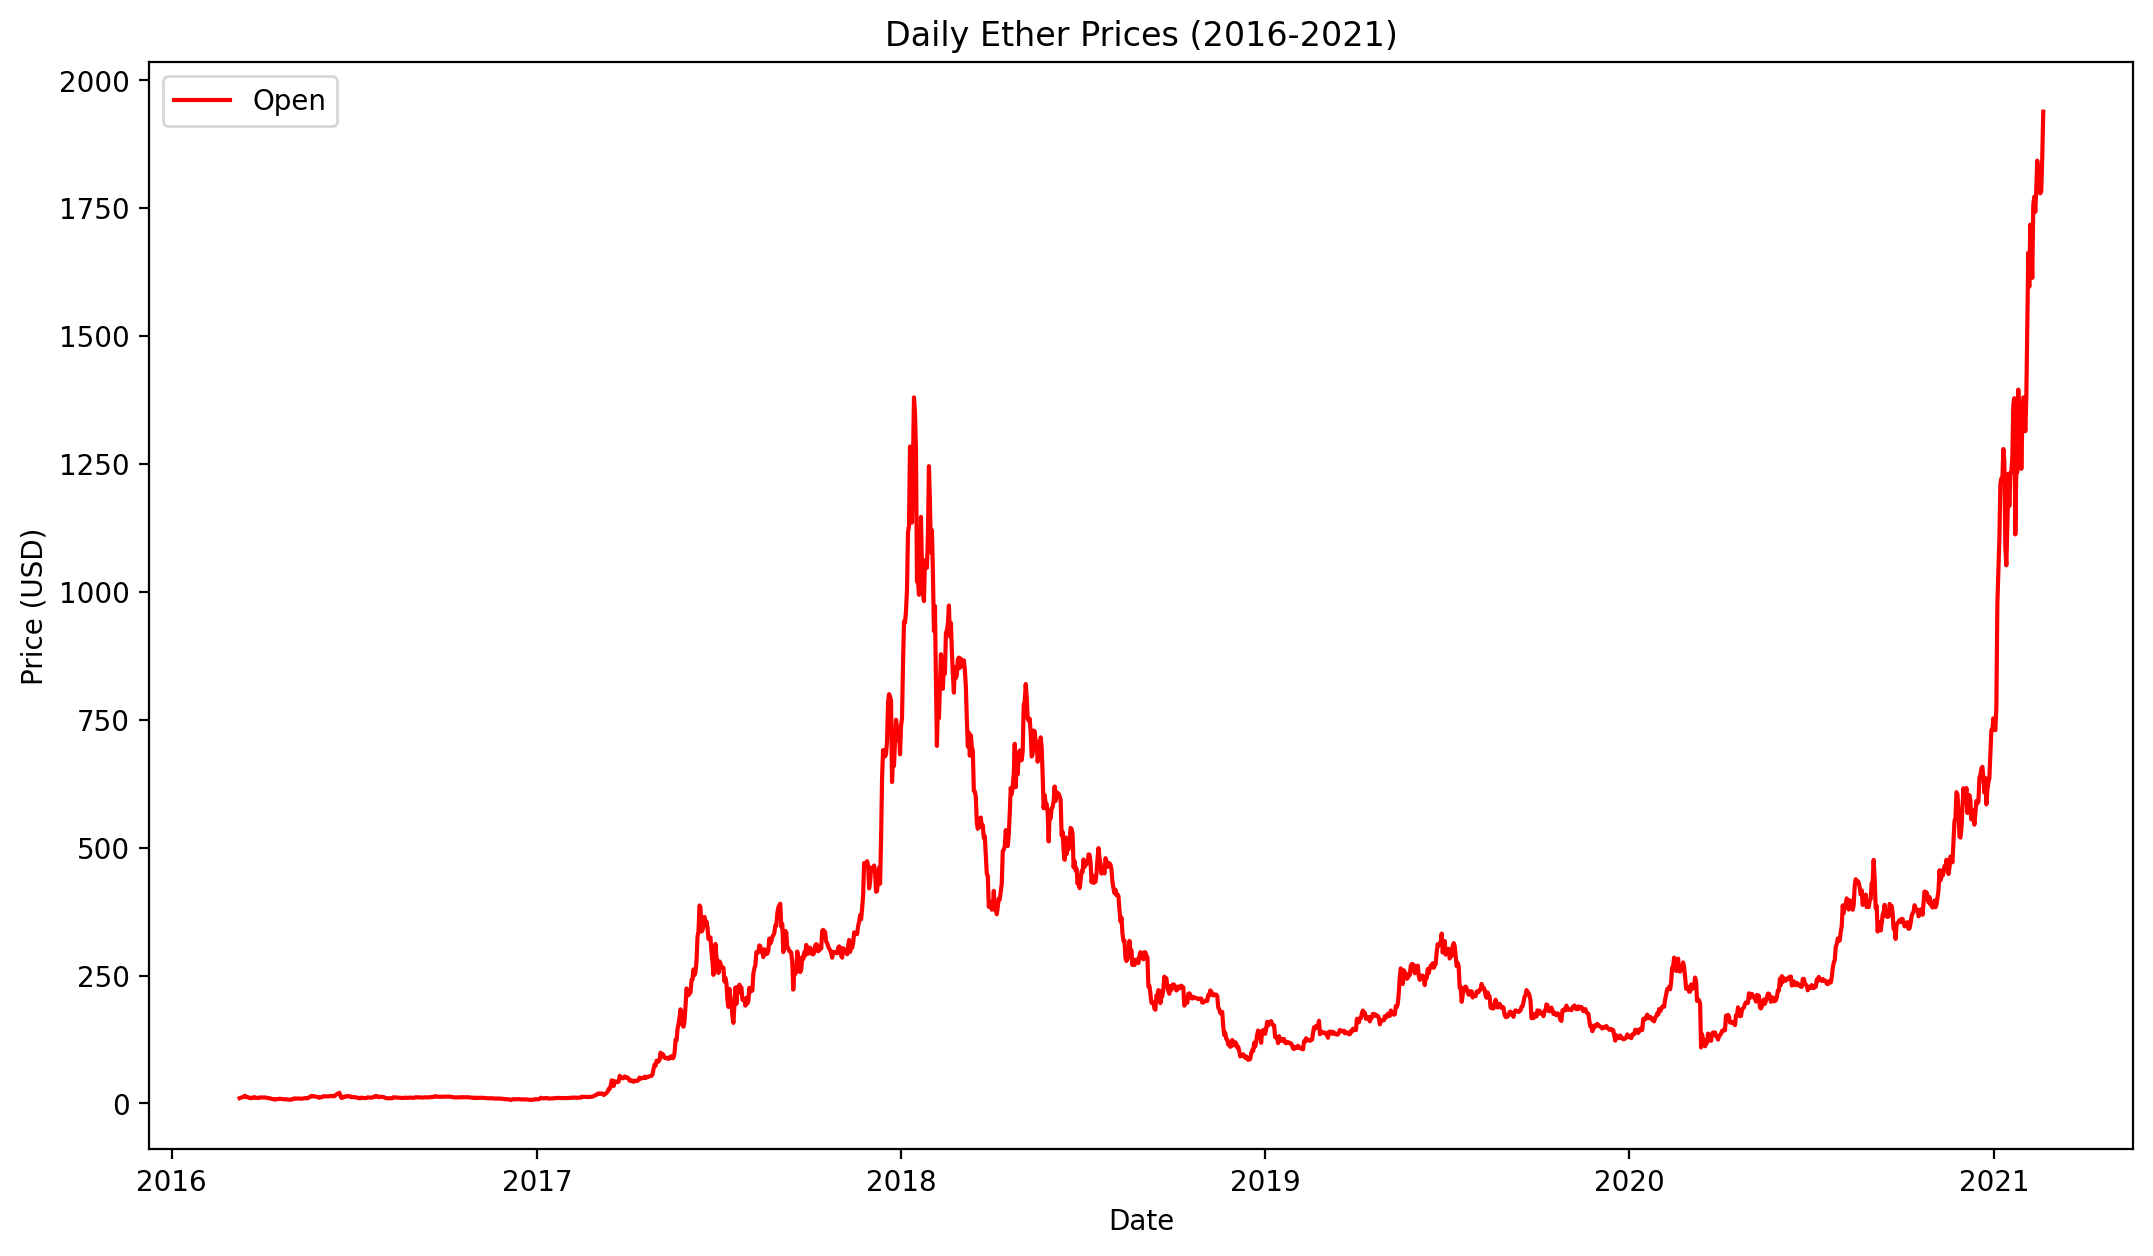

In [56]:
plot_time_series(((ether_data["Open"], "red", "Open"),), "Date", "Price (USD)", "Daily Ether Prices (2016-2021)")

In [57]:
rolling_mean = ether_data.rolling(window=30).mean()
rolling_standard_deviation = ether_data.rolling(window=30).std()
rolling_mean.dropna(axis=0, inplace=True)
rolling_standard_deviation.dropna(axis=0, inplace=True)

In [58]:
rolling_mean

,Year,Month,Weekday,Open,High,Low,Close,Volume
Date,,,,,,,,
2016-04-07,2016.0,3.233333,2.966667,11.565667,12.079333,10.838933,11.546667,11753.435000
2016-04-08,2016.0,3.266667,3.033333,11.557333,12.050667,10.822267,11.497000,11999.439000
2016-04-09,2016.0,3.300000,3.100000,11.507067,11.995667,10.753267,11.410333,12618.092333
2016-04-10,2016.0,3.333333,3.166667,11.420400,11.911667,10.612267,11.303900,14254.377667
2016-04-11,2016.0,3.366667,3.000000,11.307400,11.761067,10.480933,11.162567,14820.509000
...,...,...,...,...,...,...,...,...
2021-02-15,2021.0,1.500000,3.000000,1481.616614,1558.047252,1409.161713,1499.845528,229376.254240
2021-02-16,2021.0,1.533333,2.833333,1499.933280,1576.554196,1427.881713,1518.158862,227879.878732
2021-02-17,2021.0,1.566667,2.900000,1518.220313,1596.344196,1446.241713,1537.748862,226761.832751


In [59]:
rolling_standard_deviation

,Year,Month,Weekday,Open,High,Low,Close,Volume
Date,,,,,,,,
2016-04-07,0.000000,0.430183,1.973677,1.013841,1.115156,0.983624,1.052558,9903.109335
2016-04-08,0.000000,0.449776,1.973677,1.025563,1.149077,1.000664,1.103406,9691.536390
2016-04-09,0.000000,0.466092,2.006025,1.079233,1.197482,1.052993,1.182147,9489.478567
2016-04-10,0.000000,0.479463,2.069205,1.160395,1.285916,1.189307,1.272193,11306.092459
2016-04-11,0.000000,0.490133,2.117253,1.267190,1.361862,1.252362,1.321045,11001.142643
...,...,...,...,...,...,...,...,...
2021-02-15,0.000002,0.508548,2.117253,225.011252,218.297305,226.521344,226.017183,129265.561615
2021-02-16,0.000002,0.507416,2.069205,226.101246,216.836133,228.706069,226.092424,130456.532209
2021-02-17,0.000002,0.504007,2.006025,226.128746,214.329181,230.594896,228.490509,131594.403350


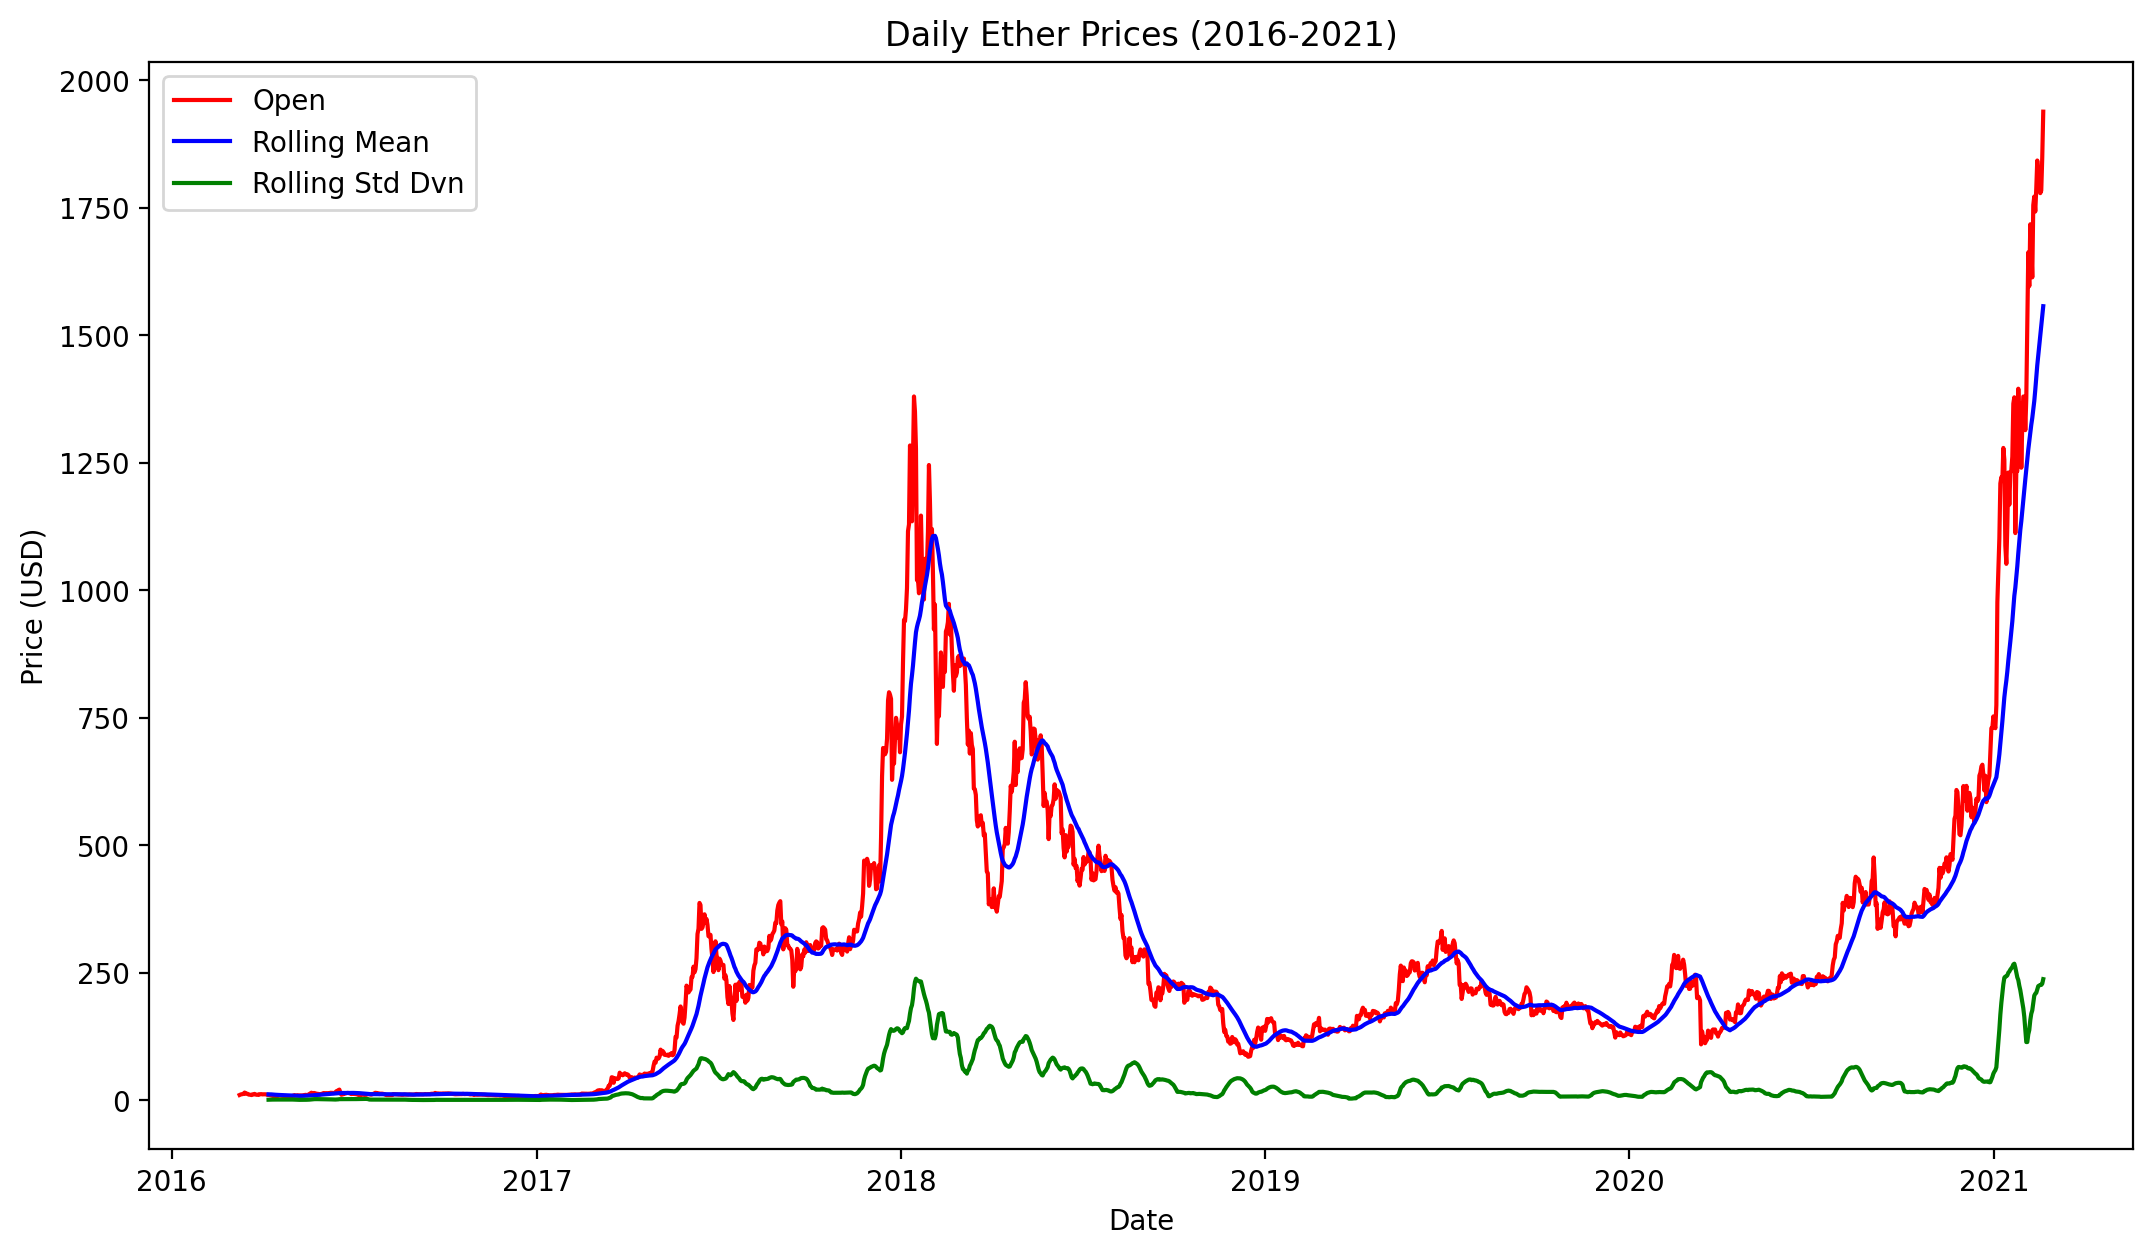

In [60]:
plot_time_series(((ether_data["Open"], "red", "Open"), (rolling_mean["Open"], "blue", "Rolling Mean"), (rolling_standard_deviation["Open"], "green", "Rolling Std Dvn")), "Date", "Price (USD)", "Daily Ether Prices (2016-2021)")

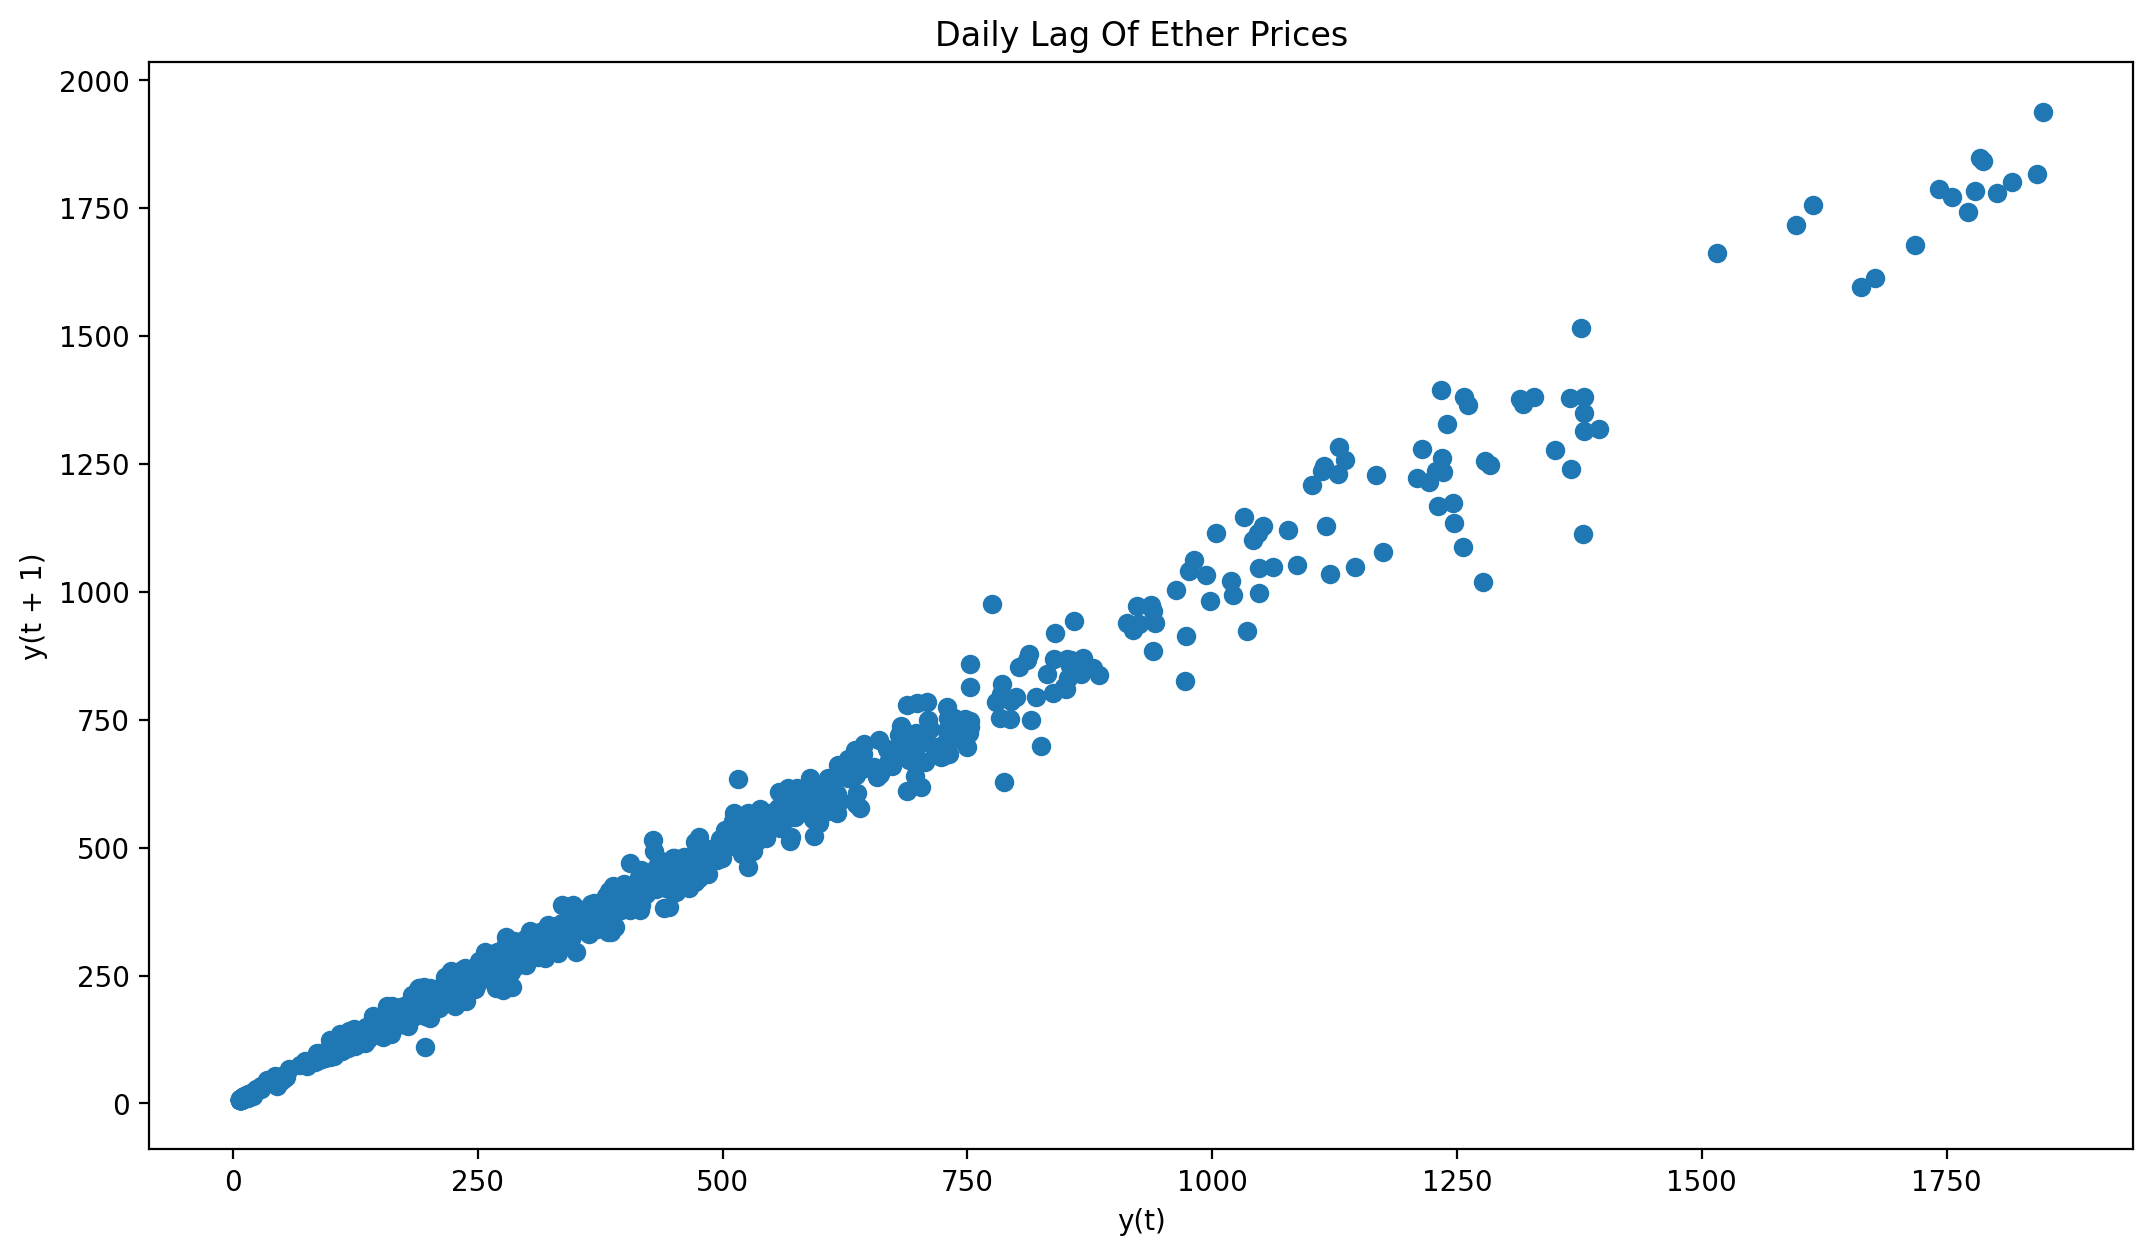

In [61]:
plot_time_series_lag(ether_data["Open"], 1, "Daily Lag Of Ether Prices")

In [62]:
training_size = int(len(ether_data) * 0.8)
test_size = len(ether_data) - training_size
train_ether_data = ether_data[:training_size]
test_ether_data = ether_data[training_size:]
train_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)
test_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)

C:\Users\samee\AppData\Local\Temp\ipykernel_10400\1028042675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)
C:\Users\samee\AppData\Local\Temp\ipykernel_10400\1028042675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)


In [63]:
train_ether_data

,Open
Date,
2016-03-09,10.30
2016-03-10,11.20
2016-03-11,11.75
2016-03-12,11.95
2016-03-13,12.92
...,...
2020-02-19,283.00
2020-02-20,258.56
2020-02-21,257.67


In [66]:
test_ether_data

,Open
Date,
2020-02-24,275.590000
2020-02-25,266.110000
2020-02-26,247.360000
2020-02-27,224.110000
2020-02-28,227.410000
...,...
2021-02-15,1801.300000
2021-02-16,1778.500000
2021-02-17,1783.710981


In [ ]:
min_max_scaler = MinMaxScaler(feature_range=(0,10))
scaled_train = min_max_scaler.fit_transform(train_ether_data)
scaled_test = min_max_scaler.fit_transform(test_ether_data)

In [ ]:
scaled_train

array([[0.02634687],
       [0.03290082],
       [0.03690601],
       ...,
       [1.82773602],
       [1.88475537],
       [1.8602873 ]])

In [ ]:
scaled_test

array([[ 0.90819116],
       [ 0.85635389],
       [ 0.75382765],
       [ 0.6266951 ],
       [ 0.64473972],
       [ 0.64698163],
       [ 0.5941601 ],
       [ 0.59640201],
       [ 0.67268154],
       [ 0.62833552],
       [ 0.63210849],
       [ 0.65562117],
       [ 0.7468832 ],
       [ 0.70324803],
       [ 0.49595363],
       [ 0.51520122],
       [ 0.50054681],
       [ 0.47080052],
       [ 0.        ],
       [ 0.14063867],
       [ 0.07589676],
       [ 0.08065398],
       [ 0.01235783],
       [ 0.03718285],
       [ 0.05014217],
       [ 0.1476378 ],
       [ 0.13128828],
       [ 0.12713255],
       [ 0.06999125],
       [ 0.14752843],
       [ 0.16043307],
       [ 0.14577865],
       [ 0.15999563],
       [ 0.11882108],
       [ 0.11887577],
       [ 0.08344269],
       [ 0.12439851],
       [ 0.12959318],
       [ 0.14736439],
       [ 0.17661855],
       [ 0.17541557],
       [ 0.1920385 ],
       [ 0.18307087],
       [ 0.33836395],
       [ 0.30293088],
       [ 0

In [ ]:
lstm_train_x, lstm_train_y = prepare_for_lstm(scaled_train, 7)
lstm_test_x, lstm_test_y = prepare_for_lstm(scaled_test, 7)
lstm_train_x = np.reshape(lstm_train_x, (lstm_train_x.shape[0], lstm_train_x.shape[1], 1))
lstm_test_x = np.reshape(lstm_test_x, (lstm_test_x.shape[0], lstm_test_x.shape[1], 1))

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=128, activation="relu", return_sequences=True, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=64, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.compile(optimizer="adam", loss="mean_squared_error")
training_result = model.fit(lstm_train_x, lstm_train_y, batch_size=32, epochs=100, verbose=1, shuffle=False, validation_data=(lstm_test_x, lstm_test_y), callbacks=None)

Epoch 1/100
45/45 [==============================] - 3s 20ms/step - loss: 0.1307 - val_loss: 0.7590
Epoch 2/100
45/45 [==============================] - 0s 8ms/step - loss: 0.3642 - val_loss: 0.1906
Epoch 3/100
45/45 [==============================] - 0s 8ms/step - loss: 0.1381 - val_loss: 0.5255
Epoch 4/100
45/45 [==============================] - 0s 8ms/step - loss: 0.2489 - val_loss: 0.1374
Epoch 5/100
45/45 [==============================] - 0s 8ms/step - loss: 0.1191 - val_loss: 0.3776
Epoch 6/100
45/45 [==============================] - 0s 8ms/step - loss: 0.2007 - val_loss: 0.1792
Epoch 7/100
45/45 [==============================] - 0s 8ms/step - loss: 0.1053 - val_loss: 0.5289
Epoch 8/100
45/45 [==============================] - 0s 8ms/step - loss: 0.2192 - val_loss: 0.1692
Epoch 9/100
45/45 [==============================] - 0s 9ms/step - loss: 0.1109 - val_loss: 0.2275
Epoch 10/100
45/45 [==============================] - 0s 8ms/step - loss: 0.1430 - val_loss: 0.2099
Epoch 11

In [77]:
training_result.history

{'loss': [0.13069945573806763,
  0.3641742765903473,
  0.1381349414587021,
  0.24887250363826752,
  0.11907361447811127,
  0.20072664320468903,
  0.10528765618801117,
  0.21920418739318848,
  0.11091732233762741,
  0.14296062290668488,
  0.1390455812215805,
  0.1240157037973404,
  0.14159280061721802,
  0.12170545011758804,
  0.16628268361091614,
  0.16657699644565582,
  0.12735918164253235,
  0.20593081414699554,
  0.11845899373292923,
  0.12051133066415787,
  0.11519894003868103,
  0.11620621383190155,
  0.12099529802799225,
  0.11359088867902756,
  0.15101946890354156,
  0.10949225723743439,
  0.11281668394804001,
  0.10479986667633057,
  0.14549969136714935,
  0.11395032703876495,
  0.11820680648088455,
  0.10807227343320847,
  0.11092102527618408,
  0.13571341335773468,
  0.12944979965686798,
  0.11367034167051315,
  0.0995282307267189,
  0.09238496422767639,
  0.10008571296930313,
  0.15438492596149445,
  0.12163227051496506,
  0.09170723706483841,
  0.15536433458328247,
  0.0841

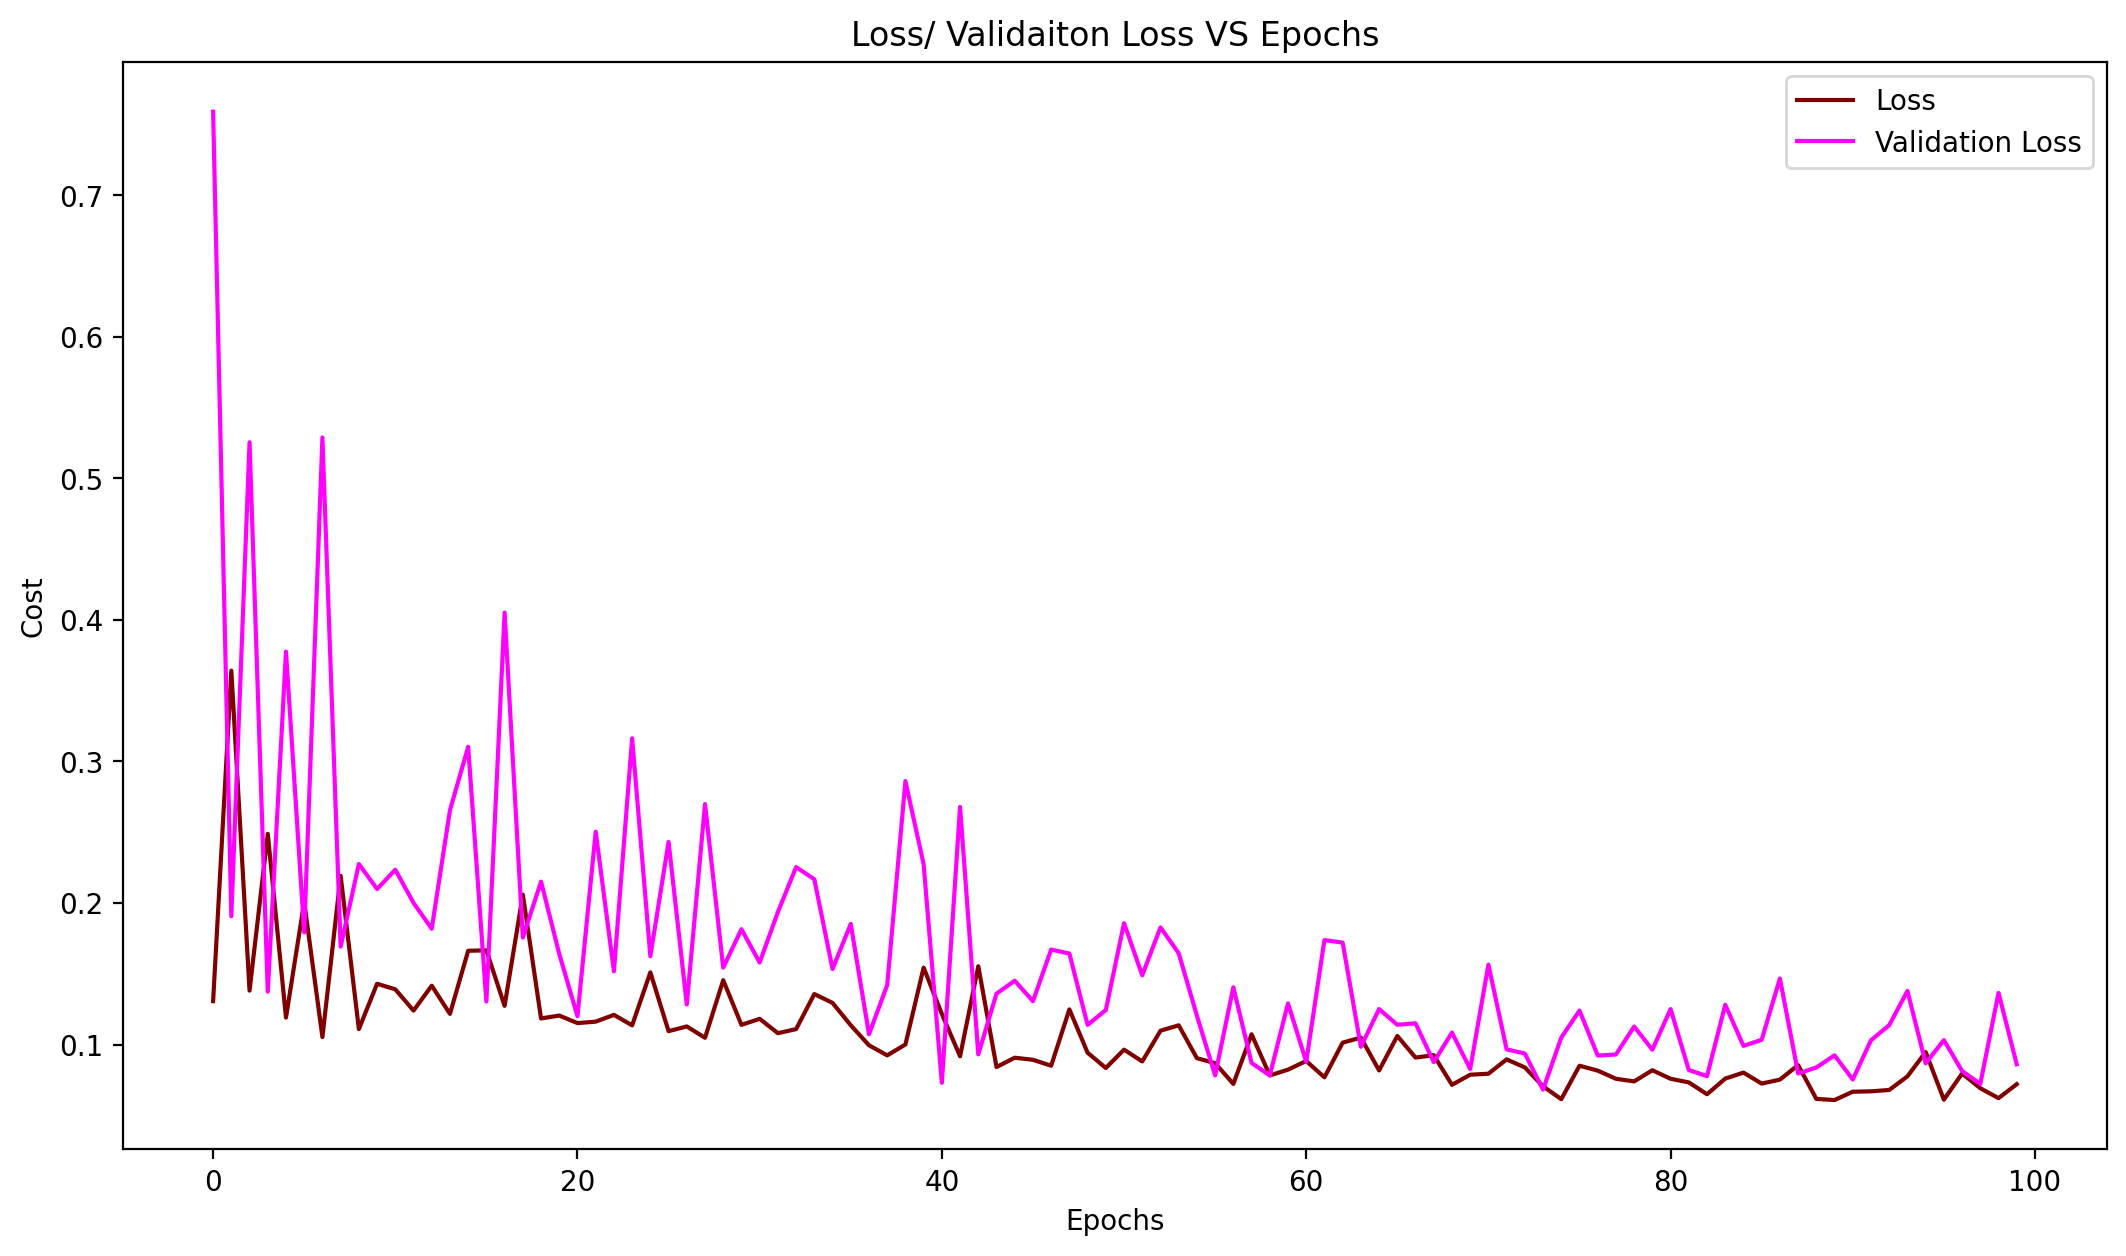

In [78]:
plt.figure(figsize=(12.80, 7.20), dpi=200)
plt.plot(training_result.history["loss"], color="maroon", label="Loss")
plt.plot(training_result.history["val_loss"], color="magenta", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Loss/ Validaiton Loss VS Epochs")
plt.show()

In [79]:
predicted_ether_data = model.predict(lstm_test_x)
predicted_ether_data = min_max_scaler.inverse_transform(predicted_ether_data.reshape(-1, 1))
actual_ether_data = min_max_scaler.inverse_transform(lstm_test_y.reshape(-1, 1))

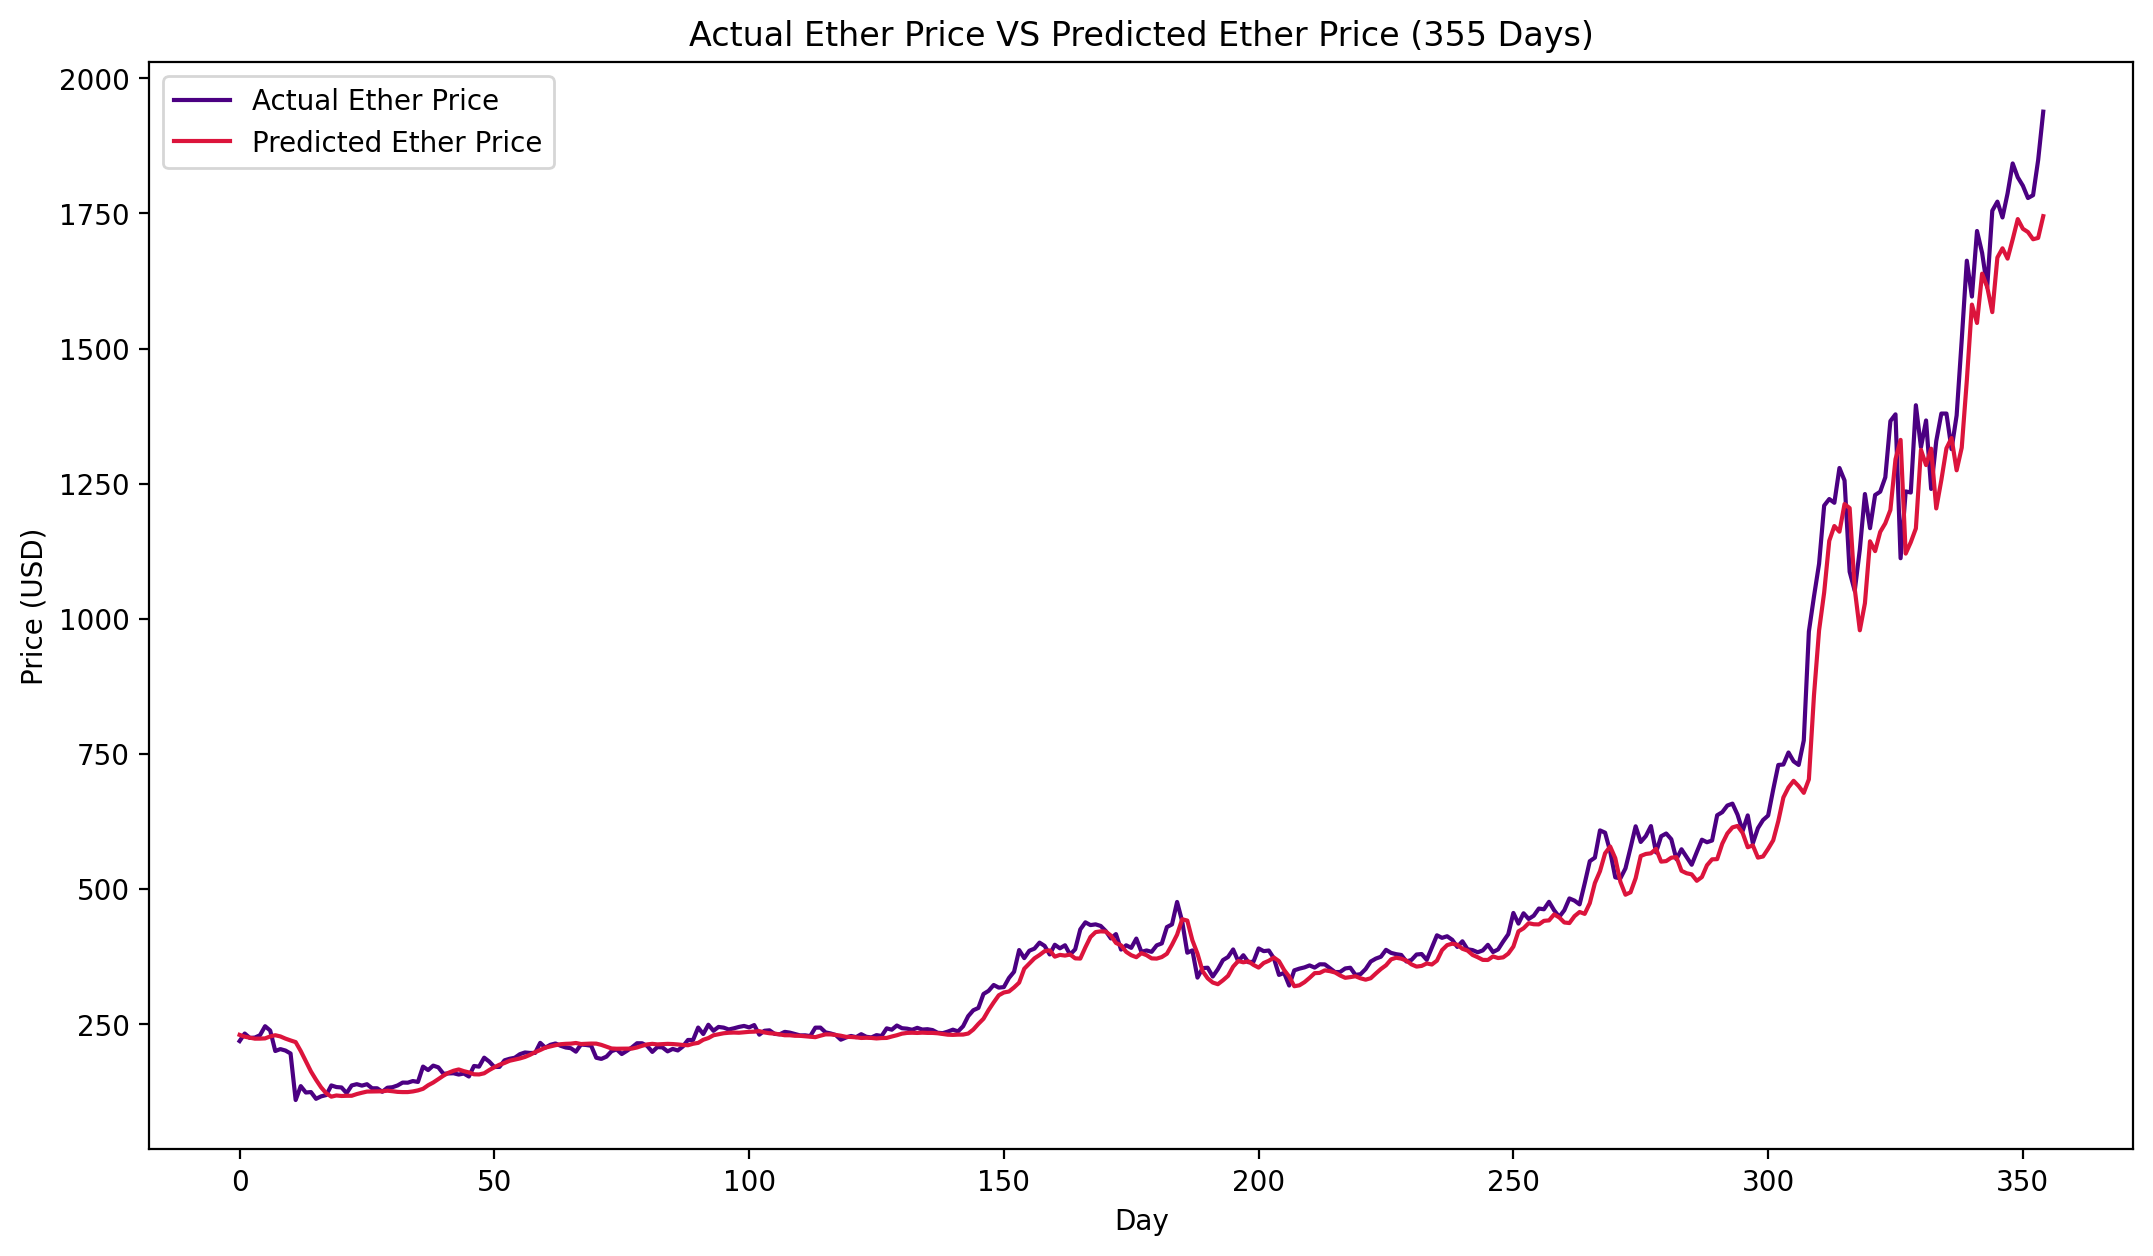

In [80]:
plt.figure(figsize=(12.80, 7.20), dpi=200)
plt.plot(actual_ether_data, color="indigo", label="Actual Ether Price")
plt.plot(predicted_ether_data, color="crimson", label="Predicted Ether Price")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Price (USD)")
plt.title("Actual Ether Price VS Predicted Ether Price (355 Days)")
plt.show()